# Data Mining - Mini Lab

#### Introduction
###### Data Description
The Dallas Crime Incident data set that is used in the Mini Project acts as a bridge between the citizens of Dallas and the Dallas PD. It represents the Dallas Police Public Data - RMS Incidents from June 1, 2014 to September 7, 2018. 
For purposes of this Mini Project, the main dataframe that is trimmed based on the analysis performed as part of Lab 1. The details of the data quality clean up and choice of columns have been detailed in the Lab 1 notebook link provided below.
Lab 1 Notebook Link - https://github.com/wtubin/MSDS7331-Data-Mining/MSDS7331_Data_Mining_Lab1_Data-Viz_Pre-Processing.ipynb


#### Objective

The objective of this unit is to perform Logistic Regression and Support Vector Machines categorization on the chosen data set and optimize the parameters in order to improve the accuracy of the model.
GitHub Repository containing the artifacts - https://github.com/wtubin/MSDS7331-Data-Mining
Location of the raw (compressed) data file - https://github.com/wtubin/MSDS7331-Data-Mining/Police_Incidents.7z 

The three models are:

- Logistic Regression, using GridSearchCV, with manual variable reduction
- Logistic Regression, using GridSearchCV, with Recursive Feature Elimination (RFE)
- Support Vector Machine (SVM)



### Create Models

##### Data Preparation

The dataset is loaded and cleaning is performed with some modifications as needed to feed into model. The attributes with zero variance (closer) or those attributes that does not have value in predicting the respose variable are removed. For example attributes like beats, sector, Location1, etc. serves no purpose for our model. 

Then dataset will be splitted into explanatory, reffered as X (Attributes) and response referred as "Y" (response variable: "Arrest_status") for running the models.

        - X : Explanatory variable (attributes)
        - Y : Response variable (Arrest_status)

The attributes will be scaled to have a mean of 0 and variance of 1 in order to imporve accuracy of the classification models. The data will then be splitted in to 80/20 training/test set split. To reduce possibility of "overfitting", 10-fold cross validation will be performed. The GrisdsearchCV method with manual variable reduction will be performed and we will be utilizing correlation scores, variance inflaion scores, variance inflation factors (VIFs) and significance for manual determination of attributes. This will help us reduce the attributes for our model.These remaining attributes will also be utilized in other two models: Logistic Regression using GridSearchCV with Recursive Feature Elimination and Support Vector Machine. The scikit-learn GridSearchCV feature will be utilized to adjust model parameters for adjusting class_weight.

Overall, accuracy, precision, and recall is determined by utilizing the modification of original function created by Dr. Drew in his Education Data Notebook for clasification to check for our proper classification success. 

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import ShuffleSplit, cross_validate
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', DeprecationWarning)
pd.set_option('mode.chained_assignment', None)

# IMPORTING DATA FROM LAB 1
path = "../Data/" # Generic path
incident = pd.read_csv(path + 'LAB1_completed_Dataset_clean.csv', low_memory= False)
print(incident.shape)
incident['Response_time'] = incident['Response_time'].fillna(incident['Response_time'].mean()).astype(np.int)
# incident['Res_time_category'] = pd.cut(incident.Response_time,[0,30,1e6],2,labels=[0,1])
# incident = incident[incident['Res_time_category'].isnull()==False]
# incident['Res_time_category'] = pd.Categorical(incident['Res_time_category']).codes

incident = incident[incident['Call_Received_Hour'].isnull()==False]

print(incident.shape)
print('Number of null columns and their counts')
incident_NullCols = incident.isnull().sum()
incident_NullCols = incident_NullCols[incident_NullCols > 0]
print(incident_NullCols)

(255154, 44)
(254091, 44)
Number of null columns and their counts
Type_Location                4856
Reporting_Area                155
Beat                           70
Sector                         70
Call_Cleared_Date_Time        165
Call_Dispatch_Date_Time        21
Offense_Status                557
Victim_Condition           233793
Family_Offense                 32
Weapon_Used                 28804
UCR_Offense_Name            14475
UCR_Code                    14475
X_Coordinate                21095
Y_Coordinate                21095
State                         608
Call_Cleared                  165
Call_Dispatch                  21
Latitude                     9755
Longitude                    9755
dtype: int64


0    229722
1     24369
Name: Arrest_status, dtype: int64


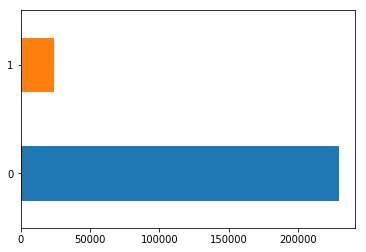

In [11]:
print(incident['Arrest_status'].value_counts())
incident['Arrest_status'].value_counts().plot(kind='barh')

In [13]:
from sklearn.utils import resample

# # Separate majority and minority classes
# incident_majority = incident[incident.Arrest_status==0]
# incident_minority = incident[incident.Arrest_status==1]
 
# # Upsample minority class
# incident_minority_upsampled = resample(incident_minority, 
#                                        replace=True,     # sample with replacement
#                                        n_samples=229722,    # to match majority class
#                                        random_state=123) # reproducible results

    
# # Combine majority class with upsampled minority class
# incident_minority_upsampled = pd.concat([incident_majority, incident_minority_upsampled])

# # Display new class counts
# incident_minority_upsampled.Arrest_status.value_counts()


# DOWNSAMPLE
df_majority = incident[incident.Arrest_status==0]
df_minority = incident[incident.Arrest_status==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=24369,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.Arrest_status.value_counts()
# 1    49

1    24369
0    24369
Name: Arrest_status, dtype: int64

In [14]:
incident= df_downsampled.copy()

In [15]:
incident.sample(2)

,Year_of_Incident,Service_Number_ID,Watch,Type_of_Incident,Type_Location,Reporting_Area,Beat,Division,Sector,Council_District,...,Location1,Call_Received,Call_Cleared,Call_Dispatch,Number_of_offense,Response_time,Latitude,Longitude,Arrest_status,Call_Received_Hour
165600,2016,213932-2016-01,2,INJURED PERSON- PUBLIC PROPERTY (OTHER THAN FI...,City Park/Rec/Tennis/Golf/Trail,6009.0,623.0,NORTH CENTRAL,620.0,D-12,...,"17400 MEANDERING WAY\r\nDALLAS, TX 75252\r\n(3...",2016-09-05 09:20:37,2016-09-05 10:32:18,2016-09-05 09:20:37,01,0,32.989115,-96.779013,0,9.0
177414,2017,073465-2017-01,3,RECKLESS DAMAGE,Parking Lot (Apartment),3055.0,521.0,NORTHWEST,520.0,D-6,...,"10106 TECHNOLOGY BLVD W\r\nDALLAS, TX 75220\r\...",2017-04-02 18:55:51,2017-04-02 23:24:10,2017-04-02 19:02:15,01,6,32.857456,-96.900528,1,18.0


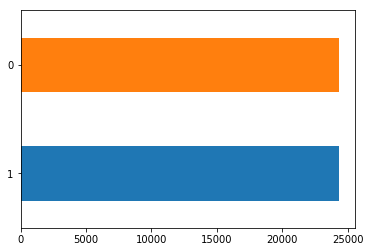

In [16]:
incident.Arrest_status.value_counts()
incident['Arrest_status'].value_counts().plot(kind='barh')


In [17]:
# UCR_Offense_Name change this

incident.loc[:,'UCR_Offense_Name'] = incident['UCR_Offense_Name'].fillna("MISSING")

THEFT_FRAUD     = dict.fromkeys(['THEFT/BMV', 'THEFT ORG RETAIL', 'BURGLARY-RESIDENCE', 'OTHER THEFTS',
                                 'ROBBERY-INDIVIDUAL','THEFT/SHOPLIFT', 'BURGLARY-BUSINESS', 'FORGE & COUNTERFEIT', 
                                 'FRAUD', 'EMBEZZLEMENT','ROBBERY-BUSINESS','THEFT ORG RETAIL'],"THEFT_FRAUD" ) 
MVA_TRAFFIC      =dict.fromkeys(['ACCIDENT MV', 'MOTOR VEHICLE ACCIDENT', 'UUMV', 'TRAFFIC VIOLATION',
                                 'TRAFFIC FATALITY'],"MVA_TRAFFIC" )        
WEAPONS_FIREARMS =dict.fromkeys(['WEAPONS', 'ARSON', 'INJURED FIREARM'], "WEAPONS_FIREARMS")         
ASSUALT          = dict.fromkeys(['ASSAULT','VANDALISM & CRIM MISCHIEF', 'AGG ASSAULT - NFV', 'OFFENSE AGAINST CHILD',
                                  'AGG ASSAULT - FV'], "ASSUALT")
OTHERS_THREATS   = dict.fromkeys(['FOUND', 'OTHERS', 'LOST', 'CRIMINAL TRESPASS', 'DISORDERLY CONDUCT', 
                                  'ANIMAL BITE','INJURED HOME','INJURED PUBLIC', 'TERRORISTIC THREAT', 
                                  'EVADING', 'INJURED OCCUPA', 'ORANIZED CRIME', 'KIDNAPPING', 
                                  'RESIST ARREST','FAIL TO ID', 'HUMAN TRAFFICKING', 'MISSING'], "OTHERS_THREATS")
INTOXICATION     = dict.fromkeys(['DRUNK & DISORDERLY', 'DWI', 'NARCOTICS & DRUGS', 'LIQUOR OFFENSE', 
                                  'INTOXICATION MANSLAUGHTER'],"INTOXICATION")
MURDER_DEATH     = dict.fromkeys(['SUDDEN DEATH&FOUND BODIES','MURDER'], "MURDER_DEATH")
                    

incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(THEFT_FRAUD)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(MVA_TRAFFIC)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(WEAPONS_FIREARMS)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(ASSUALT)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(OTHERS_THREATS)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(INTOXICATION)
incident.loc[:,'UCR_Offense_Name']= incident['UCR_Offense_Name'].replace(MURDER_DEATH)

In [18]:
# # FILTERING OUT UNNECESSARY NULL DATA
incident = incident[incident['Watch']!=0]
incident = incident[(incident['Victim_Age']>=0) & (incident['Victim_Age']<=90)]
incident = incident[incident['Victim_Race']!="Unknown"]
incident = incident[incident['Victim_Type']!="Unknown"]
incident= incident[incident.Number_of_offense != "RP"]

incident = incident[incident['Victim_Gender']!="U"]
incident.loc[:,'IsMale'] = incident.Victim_Gender=='M' 
incident.IsMale = incident.IsMale.astype(np.int)

incident.loc[:,'Social_crime_score'] = incident['Hate_Crime']+incident['Gang_Related_Offense']+incident['Drug_Related']

incident.loc[:,'Victim_Age'] = incident['Victim_Age'].astype(np.int)
# incident.loc[:,'Victim_Age_Group'] = pd.cut(incident.Victim_Age,[-1,18,30,60,999],4,labels=[0,1,2,3])

incident['UCR_Offense_Name'] = pd.Categorical(incident['UCR_Offense_Name']).codes
incident['Day1_of_the_Week'] = pd.Categorical(incident['Day1_of_the_Week']).codes
incident['Division'] = pd.Categorical(incident['Division']).codes
incident['Victim_Type'] = pd.Categorical(incident['Victim_Type']).codes
incident['Victim_Race'] = pd.Categorical(incident['Victim_Race']).codes

incident.loc[:,'Number_of_offense']= incident.Number_of_offense.astype(np.int)

In [19]:
# tmp_df = pd.get_dummies(incident.UCR_Offense_Name,prefix='UCR_Offense_Name')
# incident = pd.concat((incident,tmp_df),axis=1)

In [20]:
incident.columns

Index(['Year_of_Incident', 'Service_Number_ID', 'Watch', 'Type_of_Incident',
       'Type_Location', 'Reporting_Area', 'Beat', 'Division', 'Sector',
       'Council_District', 'Day1_of_the_Week', 'Call_Received_Date_Time',
       'Call_Cleared_Date_Time', 'Call_Dispatch_Date_Time',
       'Person_Involvement_Type', 'Victim_Type', 'Victim_Race',
       'Victim_Gender', 'Victim_Age', 'Offense_Status', 'Victim_Condition',
       'Hate_Crime', 'Family_Offense', 'Weapon_Used', 'Gang_Related_Offense',
       'Drug_Related', 'UCR_Offense_Name', 'RMS_Code', 'UCR_Code',
       'X_Coordinate', 'Y_Coordinate', 'Zip_Code', 'City', 'State',
       'Location1', 'Call_Received', 'Call_Cleared', 'Call_Dispatch',
       'Number_of_offense', 'Response_time', 'Latitude', 'Longitude',
       'Arrest_status', 'Call_Received_Hour', 'IsMale', 'Social_crime_score'],
      dtype='object')

In [21]:
# Y Response variable dataframe
inci_Y = incident['Arrest_status']

# Attributes with no predictive features with respect to resposne variable
incident = incident.drop(['Year_of_Incident','Service_Number_ID','Type_of_Incident','Type_Location', 'Reporting_Area', 
                          'Beat', 'Division', 'Sector', 'Council_District', 'Call_Received_Date_Time', 
                          'Call_Cleared_Date_Time', 'Call_Dispatch_Date_Time','Person_Involvement_Type', 'Offense_Status',
                          'Victim_Condition','Family_Offense', 'Weapon_Used', 'RMS_Code', 'UCR_Code', 
                          'Zip_Code', 'City', 'State','Location1', 'Call_Received', 'Call_Cleared', 'X_Coordinate', 
                          'Y_Coordinate','Call_Dispatch', 'Latitude', 'Longitude','Victim_Gender', 
                          'Arrest_status'],axis=1)
# 'UCR_Offense_Name'

In [22]:
incident.sample(2)

,Watch,Day1_of_the_Week,Victim_Type,Victim_Race,Victim_Age,Hate_Crime,Gang_Related_Offense,Drug_Related,UCR_Offense_Name,Number_of_offense,Response_time,Call_Received_Hour,IsMale,Social_crime_score
217320,3,2,2,3,36,0,0,0,0,1,50,22.0,1,0
242261,2,0,2,2,43,0,0,0,4,1,3,8.0,0,0


#### Cross Validation

    1. The data is divided into 80/20 train -test split.
    2. 10 folds cross validation
    3. Random seed with random state 0 for random test and training splits for each iteration of cross validation

In [23]:
from sklearn.model_selection import ShuffleSplit
#Create Cross Validation Object with 10 folds with 80/20 train - test split
cv = ShuffleSplit(n_splits = 10, test_size=0.20, random_state=0)

#Create X Explanatory Variables DF to support the individual models
inci_X = incident
inci_X_Rfe = incident
inci_X_SVM = incident
print("inci_X", inci_X.info())
print("inci_X_Rfe", inci_X_Rfe.info())
print("inci_X_SVM", inci_X_SVM.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44575 entries, 97993 to 255143
Data columns (total 14 columns):
Watch                   44575 non-null int64
Day1_of_the_Week        44575 non-null int8
Victim_Type             44575 non-null int8
Victim_Race             44575 non-null int8
Victim_Age              44575 non-null int32
Hate_Crime              44575 non-null int64
Gang_Related_Offense    44575 non-null int64
Drug_Related            44575 non-null int64
UCR_Offense_Name        44575 non-null int8
Number_of_offense       44575 non-null int32
Response_time           44575 non-null int32
Call_Received_Hour      44575 non-null float64
IsMale                  44575 non-null int32
Social_crime_score      44575 non-null int64
dtypes: float64(1), int32(4), int64(5), int8(4)
memory usage: 3.2 MB
inci_X None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 44575 entries, 97993 to 255143
Data columns (total 14 columns):
Watch                   44575 non-null int64
Day1_of_the_Week  

##### Colinearity

The dataset had few issues with collinearity, this issue was found during ther LAB 1 iteration of data exploration. 

###### Starting Colinearity
Some of the attributes which were hightly correlated comes from either creation of new columns or they are derived from date related varibales or splitted from original categories.

In [24]:
#Create correlation matrix
CorrMat = incident.corr()

# Highest Correlation Pairs
corrPairs = CorrMat.unstack().sort_values(kind="quicksort", ascending=False)
#- REMOVE DUPLICATES
corrPairs = corrPairs[::2]
corrPairs = corrPairs[corrPairs.index.get_level_values(0) != corrPairs.index.get_level_values(1)]
with pd.option_context('display.max_rows',10):
    print(corrPairs)

Social_crime_score  Drug_Related            0.844348
Call_Received_Hour  Watch                   0.715448
Social_crime_score  Gang_Related_Offense    0.559378
Hate_Crime          Social_crime_score      0.145233
Victim_Race         UCR_Offense_Name        0.128761
                                              ...   
Drug_Related        Response_time          -0.048497
UCR_Offense_Name    Call_Received_Hour     -0.051800
Response_time       Number_of_offense      -0.059619
Social_crime_score  Response_time          -0.060529
UCR_Offense_Name    Watch                  -0.102501
Length: 91, dtype: float64


Ending Colinearity
The highly correlated attributes were manually removed from dataset. 
- Total attributes removed : 4

In [25]:

#Drop highly correlated, insignificant and high VIF columns.
inci_X = incident.drop(['Drug_Related','Watch','Gang_Related_Offense','Hate_Crime'], axis=1)

#Create correlation matrix
CorrMat = inci_X.corr()

# Highest Correlation Pairs
corrPairs = CorrMat.unstack().sort_values(kind="quicksort", ascending=False)
#- REMOVE DUPLICATES
corrPairs = corrPairs[::2]
corrPairs = corrPairs[corrPairs.index.get_level_values(0) != corrPairs.index.get_level_values(1)]
with pd.option_context('display.max_rows',10):
    print(corrPairs)

Victim_Race        UCR_Offense_Name      0.128761
Number_of_offense  Social_crime_score    0.114217
Victim_Age         Victim_Race           0.103129
UCR_Offense_Name   Response_time         0.085079
Response_time      Call_Received_Hour    0.075360
                                           ...   
                   IsMale               -0.032653
Number_of_offense  Victim_Age           -0.037295
UCR_Offense_Name   Call_Received_Hour   -0.051800
Number_of_offense  Response_time        -0.059619
Response_time      Social_crime_score   -0.060529
Length: 45, dtype: float64


###### Scale Data
In order to imporve accuracy and performance of our classification model and to prevent emphasis of one attribute over the other, attributes are scaled to have a mean of 0 and variance of 1 for all models in this report.Several features in the data set are decimal measurements that will never exceed 1.


In [26]:
from sklearn.preprocessing import StandardScaler

#Scale data
scaler = StandardScaler()
inci_X_scaled = scaler.fit_transform(inci_X)
inci_X_Rfe_scaled = scaler.fit_transform(inci_X_Rfe)
inci_X_SVM_scaled = scaler.fit_transform(inci_X_SVM)

#Save as data frames
df_inci_X_scaled = pd.DataFrame(inci_X_scaled)
df_inci_X_Rfe_scaled = pd.DataFrame(inci_X_Rfe_scaled)
df_inci_X_SVM_scaled= pd.DataFrame(inci_X_SVM_scaled)

#### Variance Inflation Factors (VIF)

The attributes analysis and scaling is indicated with hight variance inflation factors. Generally acceptable value should be under 10. This will help create better model. 

###### Initially, for manual reduction method for Logistic regression VIF is, 

In [27]:
# Credit: https://etav.github.io/

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
df2_vif = pd.DataFrame()
df2_vif["VIF Factor"] = [vif(inci_X.values, i) for i in range(inci_X.shape[1])]
df2_vif["features"] = inci_X.columns
df2_vif

,VIF Factor,features
0,3.206119,Day1_of_the_Week
1,23.703671,Victim_Type
2,5.367930,Victim_Race
3,8.389207,Victim_Age
4,2.411270,UCR_Offense_Name
5,5.244311,Number_of_offense
6,1.599774,Response_time
7,4.983291,Call_Received_Hour
8,2.186495,IsMale
9,1.040722,Social_crime_score


##### Applying threshold of 10 VIF is,
After applying a threshold of 10 and using the Logistic Regression-with manual variable reduction, dataset, the VIF factors have been reduced significantly and are in an acceptable range.

In [28]:
# Credit: https://etav.github.io/

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

df2_vif = pd.DataFrame()
df2_vif["VIF Factor"] = [vif(df_inci_X_scaled.values, i) for i in range(df_inci_X_scaled.shape[1])]
df2_vif["features"] = inci_X.columns
df2_vif

,VIF Factor,features
0,1.001296,Day1_of_the_Week
1,1.001022,Victim_Type
2,1.030074,Victim_Race
3,1.018395,Victim_Age
4,1.031625,UCR_Offense_Name
5,1.018120,Number_of_offense
6,1.022090,Response_time
7,1.010084,Call_Received_Hour
8,1.014295,IsMale
9,1.018448,Social_crime_score


### FEATURE SIGNIFICANCE

In [29]:
# LOGISTIC REGRESSION: SUMMARY TABLE WITHOUT SCALING- FEATURE SIGNIFICANCE, CROSS VALIDATION OF FULL MODEL

import statsmodels.api as sm
logit_model = sm.Logit(inci_Y, inci_X)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.621226
         Iterations 6
                          Results: Logit
Model:                Logit            Pseudo R-squared: 0.103     
Dependent Variable:   Arrest_status    AIC:              55402.2746
Date:                 2018-10-04 21:20 BIC:              55489.3239
No. Observations:     44575            Log-Likelihood:   -27691.   
Df Model:             9                LL-Null:          -30866.   
Df Residuals:         44565            LLR p-value:      0.0000    
Converged:            1.0000           Scale:            1.0000    
No. Iterations:       6.0000                                       
-------------------------------------------------------------------
                    Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------
Day1_of_the_Week   -0.0015   0.0051  -0.2819 0.7780 -0.0115  0.0086
Victim_Type         0.3779   0.0269  14.0

## Logistic Regresssion

##### Classifier Evaluation

- Functions and code utilized from Dr. Drew's NC models 
https://github.com/jakemdrew/EducationDataNC/blob/master/2016/Models/2016ComparingSegregatedHighSchoolCampuses.ipynb

In [30]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

results = []

def EvaluateClassifierEstimator(classifierEstimator, X, y, cv, model):
   
    #Perform cross validation 
    scores = cross_validate(classifierEstimator, inci_X, inci_Y, scoring=['accuracy','precision','recall']
                            , cv=cv, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Recavg = scores['test_recall'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average recall for all cv folds is: \t\t\t {Recavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Recavg=Recavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']
    
    results.append({'Model': model, 'Accuracy': Accavg, 'Precision': Preavg, 'Recall': Recavg})

    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X, y, cv):
    
    #Perform cross validation 
    from sklearn.model_selection import cross_val_predict
    predictions = cross_val_predict(classifierEstimator, inci_X, inci_Y, cv=cv)
    
    #model evaluation 
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    
    #pass true test set values and predictions to classification_report
    classReport = classification_report(Y,predictions)
    confMat = confusion_matrix(Y,predictions)
    acc = accuracy_score(Y,predictions)
    
    print (classReport)
    print (confMat)
    print (acc)

##### GridSearchCV Logistic Regression with Manual Feature Reduction

In [31]:
#Logisitic regression 10-fold cross-validation 
from sklearn.linear_model import LogisticRegression
regEstimator = LogisticRegression()

parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced', 'none']
              ,'random_state': [0]
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
#regGridSearch.fit(teamX, teamY)
regGridSearch.fit(df_inci_X_scaled, inci_Y)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    9.9s
[Parallel(n_jobs=8)]: Done 280 out of 280 | elapsed:   12.3s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': ['balanced', 'none'], 'random_state': [0], 'solver': ['lbfgs'], 'max_iter': [100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [32]:
#Diplay the top model parameters
regGridSearch.best_estimator_.coef_

array([[-0.00337824, -0.00761008, -0.06346228, -0.08420255, -0.64078572,
         0.24593042, -0.34527114,  0.05538089,  0.05224478,  0.11276932]])

#### Accuacy Precision, Recall, Attribute Weights, Model Parameters
Average accuracy, precision, and recall for the cross-validation folds is listed below.

In [33]:
#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
print("\n",round(EvaluateClassifierEstimator(classifierEst, df_inci_X_scaled, inci_Y, cv, "manual"),4))

#Use the best parameters for our Linear Regression object",
ClassiferParams = regGridSearch.best_params_
print("\n---- Logistic Regression - CV, Scaled 'Manual' Attr Elimination ----")
for keys,values in ClassiferParams.items():
    print(keys,": \t ",values)
    
# sort these attributes and spit them out\n",
name = inci_X
zip_vars = zip(regGridSearch.best_estimator_.coef_.T,name) # combine attributes
zip_vars = sorted(zip_vars, reverse=True)

# Print out Attributes and their weights\n",
print("\n---- Attributes and their weights -----\n")
for coef, name in zip_vars:
    print(name, ' has weight of', coef[0])

The average accuracy for all cv folds is: 			 0.66312
The average precision for all cv folds is: 			 0.69637
The average recall for all cv folds is: 			 0.625
*********************************************************
Cross Validation Fold Mean Error Scores

    Accuracy  Precision  Recall
0    0.6583     0.6884  0.6257
1    0.6635     0.6958  0.6232
2    0.6498     0.6762  0.6147
3    0.6637     0.6918  0.6302
4    0.6781     0.7113  0.6417
5    0.6738     0.7092  0.6308
6    0.6601     0.6991  0.6162
7    0.6547     0.6981  0.6168
8    0.6681     0.7062  0.6310
9    0.6610     0.6874  0.6196

---- Logistic Regression - CV, Scaled 'Manual' Attr Elimination ----
C : 	  0.1
class_weight : 	  balanced
max_iter : 	  100
penalty : 	  l2
random_state : 	  0
solver : 	  lbfgs

---- Attributes and their weights -----

Number_of_offense  has weight of 0.24593041642891186
Social_crime_score  has weight of 0.11276932033026024
Call_Received_Hour  has weight of 0.055380887710225465
IsMale  has weig

In [34]:
print("Best Estimator GridSearch Prediction")
print(regGridSearch.best_estimator_.predict(df_inci_X_scaled))
print(regGridSearch.best_estimator_.predict_proba(df_inci_X_scaled))

Best Estimator GridSearch Prediction
[0 0 0 ... 1 1 1]
[[0.78537362 0.21462638]
 [0.71778921 0.28221079]
 [0.63661482 0.36338518]
 ...
 [0.36908661 0.63091339]
 [0.40981823 0.59018177]
 [0.36316785 0.63683215]]


##### GridSearchCV Logistic Regression with Recursive Feature Elimination

In [35]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit


print("RFE CV Logistic Regression 1st Pass")
rfecvEstimator = LogisticRegression()

parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced', 'none']
              ,'random_state': [0]
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
rfecvGridSearch = GridSearchCV(estimator=rfecvEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data using RFECV
rfecvGridSearch.fit(df_inci_X_Rfe_scaled, inci_Y)

#Use the best parameters for our RFECV Linear Regression object
rfecvClassifierEst = rfecvGridSearch.best_estimator_

#Recursive Feature Elimination
rfecv = RFECV(estimator=rfecvClassifierEst, step=1, cv=cv, scoring='accuracy', verbose=1)
#X_BestFeatures = rfecv.fit_transform(teamX, teamY)
X_BestFeatures = rfecv.fit_transform(df_inci_X_Rfe_scaled, inci_Y)

#Print RFECV Details
print("Ranking", rfecv.ranking_)
print("Support", rfecv.support_)
print("Number of Features:", rfecv.n_features_)

print("Logistic Regression Second Pass")
#create a pipeline to scale all of the data and perform logistic regression during each grid search step.
pipe = make_pipeline(StandardScaler(), LogisticRegression())

#Define a range of hyper parameters for grid search
parameters = { 'logisticregression__penalty':['l2']
              ,'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'logisticregression__class_weight': ['balanced','none']
              ,'logisticregression__random_state': [0]
              ,'logisticregression__solver': ['lbfgs']
              ,'logisticregression__max_iter':[100,500]
             }

#Perform the grid search using accuracy as a metric during cross validation.
grid = GridSearchCV(pipe, parameters, cv=cv, scoring='accuracy')

#Use the best features from recursive feature elimination during the grid search
grid.fit(df_inci_X_Rfe_scaled, inci_Y)

RFE CV Logistic Regression 1st Pass
Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    6.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   11.0s
[Parallel(n_jobs=8)]: Done 280 out of 280 | elapsed:   13.6s finished


Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting 

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logisticregression__penalty': ['l2'], 'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'logisticregression__class_weight': ['balanced', 'none'], 'logisticregression__random_state': [0], 'logisticregression__solver': ['lbfgs'], 'logisticregression__max_iter': [100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [36]:
#Use the best parameters from RFE for our Linear Regression object

EvaluateClassifierEstimator(rfecvClassifierEst, df_inci_X_Rfe_scaled, inci_Y, cv, 'Rfe')

The average accuracy for all cv folds is: 			 0.66117
The average precision for all cv folds is: 			 0.69519
The average recall for all cv folds is: 			 0.62103
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.655637,0.686204,0.621627
1,0.663040,0.696000,0.621294
2,0.648458,0.675565,0.611450
3,0.661133,0.689606,0.626302
4,0.675042,0.709104,0.636481
5,0.671340,0.707359,0.626727
6,0.659899,0.700564,0.612337
7,0.653169,0.698168,0.611486
8,0.666854,0.705361,0.628895
9,0.657095,0.684005,0.613716


###### Reiteration of manual feature reduction of Logistic Regression

In [37]:
print(grid.best_estimator_.predict(df_inci_X_Rfe_scaled))
print(grid.best_estimator_.predict_proba(df_inci_X_Rfe_scaled))

#Use the best parameters for our RFE  Regression object
rfecvClassifierEst = rfecvGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
print("\n",round(EvaluateClassifierEstimator(rfecvClassifierEst, df_inci_X_Rfe_scaled, inci_Y, cv, "manual"),4))

#Use the best parameters for our RFECV Regression object",
rfecvClassiferParams = rfecvGridSearch.best_params_
print("\n---- RFECV Regression - CV, Scaled ----")
for keys,values in rfecvClassiferParams.items():
    print(keys,": \t ",values)
    
# sort these attributes and spit them out\n",
name = inci_X
zip_vars = zip(rfecvGridSearch.best_estimator_.coef_.T,name) # combine attributes
zip_vars = sorted(zip_vars, reverse=True)

# Print out Attributes and their weights\n",
print("\n---- Attributes and their weights -----\n")
for coef, name in zip_vars:
    print(name, ' has weight of', coef[0])

[0 0 0 ... 1 1 1]
[[0.80579736 0.19420264]
 [0.70005064 0.29994936]
 [0.62742951 0.37257049]
 ...
 [0.33173667 0.66826333]
 [0.3590594  0.6409406 ]
 [0.33524117 0.66475883]]
The average accuracy for all cv folds is: 			 0.66117
The average precision for all cv folds is: 			 0.69519
The average recall for all cv folds is: 			 0.62103
*********************************************************
Cross Validation Fold Mean Error Scores

    Accuracy  Precision  Recall
0    0.6556     0.6862  0.6216
1    0.6630     0.6960  0.6213
2    0.6485     0.6756  0.6114
3    0.6611     0.6896  0.6263
4    0.6750     0.7091  0.6365
5    0.6713     0.7074  0.6267
6    0.6599     0.7006  0.6123
7    0.6532     0.6982  0.6115
8    0.6669     0.7054  0.6289
9    0.6571     0.6840  0.6137

---- RFECV Regression - CV, Scaled ----
C : 	  0.01
class_weight : 	  balanced
max_iter : 	  100
penalty : 	  l2
random_state : 	  0
solver : 	  lbfgs

---- Attributes and their weights -----

Day1_of_the_Week  has weight o

## SUPPORT VECTOR MACHINE (SVM)

In [38]:
%%time

#SVM model on main dataframe.
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn import metrics as mt


#train the model just as before
svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto') # get object
svm_clf.fit(df_inci_X_SVM_scaled, inci_Y)  # train object

y_hat = svm_clf.predict(df_inci_X_SVM_scaled)

acc = mt.accuracy_score(inci_Y,y_hat)
conf = mt.confusion_matrix(inci_Y,y_hat)
prec = mt.precision_score(inci_Y, y_hat)
recall = mt.recall_score(inci_Y, y_hat)
print('accuracy:', acc )
print('precision:', prec)
print('recall:', recall)
print(conf)

results.append({'Model': 'SVM', 'Accuracy': acc, 'Precision': prec, 'Recall': recall})

accuracy: 0.6607515423443634
precision: 0.6993366252680931
recall: 0.6065758165693272
[[15432  6028]
 [ 9094 14021]]
Wall time: 2min 1s


In [39]:
#look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(32533, 14)
(32533,)
[16217 16316]


In [44]:
# SVM based Prediction
print(y_hat)

[0 0 0 ... 1 1 1]


## Create Model Summary

- The three models: 
    - Logistic regression with manual selection, 
    - Logistic regression with RFE selection, 
    - Support Vector Machine (SVM) 
    
These models were executed successfully. The models were cross validated with controls. 

- Stochastic Gradient Descent was not utilized for the support vector machine model ...................***

- The "GridSearchCV Logistic Regression with manual variable reduction" model ultimately produced the best accuracy and overall results. The results are summarized in the table below.


In [45]:
df_results = pd.DataFrame(results)
df_results = df_results[['Model', 'Accuracy', 'Precision', 'Recall']]
df_results

,Model,Accuracy,Precision,Recall
0,manual,0.663118,0.696369,0.625000
1,Rfe,0.661167,0.695194,0.621032
2,manual,0.661167,0.695194,0.621032
3,SVM,0.660752,0.699337,0.606576


### Model Advantages

For classification analysis both Logistic regression and Support Vector Machines are common machine learning algorithms for creating models.

- Logistic regression

    - For maximizing the probability of the data, logistic regression models are generally good. The accuracy of model is acheived at its best in these type of models when data points are distictly separated far away from hyperplane.
    - This is more probablistic model.
    - RFE (Recursive Feature Elimination) model chooses the peformance of feature and repeats process until all attibutes are analyzed. 

- Support Vector Machine

    - By definition, SVM models tired to score on hyperplane which maximizes the distance closest to margin or support vectors.
    - This is deterministic model.
    - The SVM model creates hyperplane and puts source data in these dimensional space which is different from original data and is analyzed accordingly. 


Generally, from the results produced by our models both Logistic Regrerssion and SVM have similar accuracy. However, manual and RFE model of Logistic regression performed well in terms of precision and recall then SVM. In terms of accuracy, manual and RFE model has 89.77%, whereas SVM had 89.74% accuracy, which is with less than 1% of each other. 
In terms of precision, which means correctly classified classes, RFE and manual models had 60.87% precision. SVM did not perform well for out dataset or our variable selection. Overall, the manual************ and RFE logistic regression model performed best for our dataset. 




## Feature Importance for Logistic Regression
In logistic models, feature weights will provide us with importance of attribute. We can compare RFE and manual models in terms of weight as both were normalized.

###### Manual Variable Selection Model

*** EXPLANATION RELATED TO ATTRIBUTES 

###### Recursive Selection Model

*** EXPLANATION RELATED TO ATTRIBUTES 

In [46]:
from matplotlib import pyplot as plt

def plotCoef(coef, names, t):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names), key=lambda x: abs(x[0])))
    plt.figure(figsize=(9,12))
    barlist = plt.barh(range(len(names)), imp, align='center')
    for x in np.nditer(np.where(np.asarray(list(imp)) < 0)):
        barlist[x].set_color('r')
    plt.yticks(range(len(names)), names)
    plt.title(t)
    plt.show()



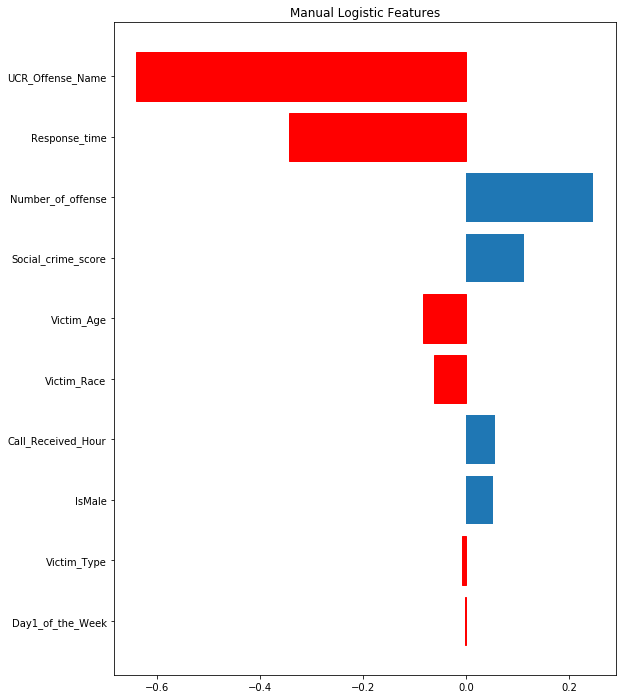

[(-0.6407857249586137, 'UCR_Offense_Name'),
 (-0.34527114138224574, 'Response_time'),
 (-0.08420254799155008, 'Victim_Age'),
 (-0.06346228063831894, 'Victim_Race'),
 (-0.007610076616263498, 'Victim_Type'),
 (-0.0033782428756917505, 'Day1_of_the_Week'),
 (0.0522447849079184, 'IsMale'),
 (0.055380887710225465, 'Call_Received_Hour'),
 (0.11276932033026024, 'Social_crime_score'),
 (0.24593041642891186, 'Number_of_offense')]

In [47]:
plotCoef(regGridSearch.best_estimator_.coef_[0], inci_X.columns.values, "Manual Logistic Features")
list(sorted(zip(regGridSearch.best_estimator_.coef_.ravel(), inci_X.columns.values)))

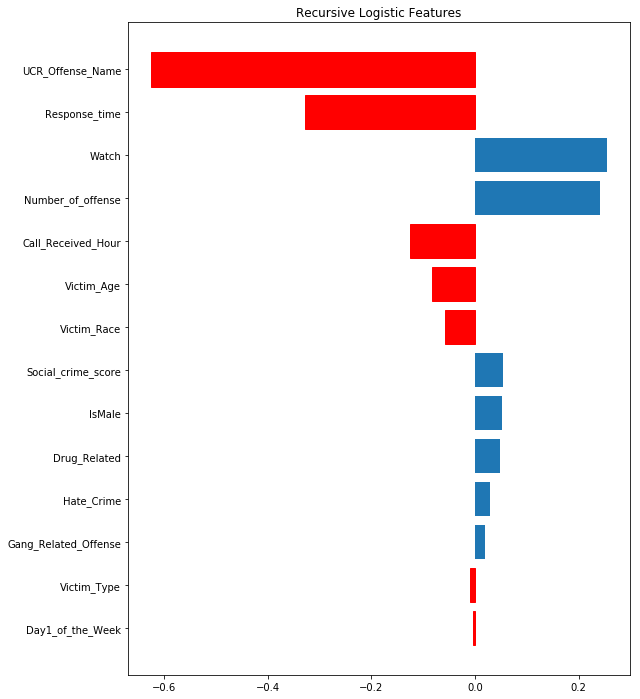

[(-0.6250428553255511, 'UCR_Offense_Name'),
 (-0.32851638191142457, 'Response_time'),
 (-0.12587801764935178, 'Call_Received_Hour'),
 (-0.08282666908855692, 'Victim_Age'),
 (-0.0576937899046972, 'Victim_Race'),
 (-0.010401679705952429, 'Victim_Type'),
 (-0.0036457329032076407, 'Day1_of_the_Week'),
 (0.01859940559727112, 'Gang_Related_Offense'),
 (0.02978302632676834, 'Hate_Crime'),
 (0.049089114544554016, 'Drug_Related'),
 (0.05286228524303158, 'IsMale'),
 (0.05412702410926804, 'Social_crime_score'),
 (0.2406454318258666, 'Number_of_offense'),
 (0.255342276580128, 'Watch')]

In [48]:
plotCoef(grid.best_estimator_.named_steps['logisticregression'].coef_.ravel(), inci_X_Rfe.columns.values, "Recursive Logistic Features")
list(sorted(zip(grid.best_estimator_.named_steps['logisticregression'].coef_.ravel(), inci_X_Rfe.columns.values)))

## SGD Classifier

In [49]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


class EncodeCategorical(BaseEstimator, TransformerMixin):
    """
    Encodes a specified list of columns or all columns if None.
    """

    def __init__(self, columns=None):
        self.columns  = [col for col in columns]
        self.encoders = None

    def fit(self, data, target=None):
        """
        Expects a data frame with named columns to encode.
        """
        # Encode all columns if columns is None
        if self.columns is None:
            self.columns = data.columns

        # Fit a label encoder for each column in the data frame
        self.encoders = {
            column: LabelEncoder().fit(data[column])
            for column in self.columns
        }
        return self

    def transform(self, data):
        """
        Uses the encoders to transform a data frame.
        """
        output = data.copy()
        for column, encoder in self.encoders.items():
            output[column] = encoder.transform(data[column])

        return output
    
    
# precision = true positives / (true positives + false positives)

# recall = true positives / (false negatives + true positives)

# F1 score = 2 * ((precision * recall) / (precision + recall))


from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline


def model_selection(X, y, estimator):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y.values.ravel())
    model = Pipeline([
         ('label_encoding', EncodeCategorical(X.keys())),
         ('one_hot_encoder', OneHotEncoder()),
         ('estimator', estimator)
    ])

    # Instantiate the classification model and visualizer
    model.fit(X, y)

    expected  = y
    predicted = model.predict(X)

    # Compute and return the F1 score (the harmonic mean of precision and recall)
    return (f1_score(expected, predicted))

In [50]:
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

model_selection(df_inci_X_SVM_scaled, inci_Y, SGDClassifier())

0.6108665958415541

### Interpreting SVM Fields

For SVM models, the interpretation of field importance is not as straight forward. Non-linear SVM models create hyperplanes in infinite dimensional space. To accomplish this the source data used in the analysis must be mapped to a higher dimentional space and as a result is very different from the original data. Because of this it is not possible to determine feature weights like we did with the logisitc regessions above.

However, we can examine individual features to investigate how SVM approaches classification problems.**** EXPLANATION

In [ ]:
# #Credit To:
# ####http://scikit-learn.org/stable/auto_examples/svm/plot_iris.html
# from matplotlib import pyplot as plt

# #R and RA
# pX = pd.DataFrame()

# pX['a'] = inci_X_SVM['IsMale']
# pX['b'] = inci_X_SVM['Number_of_offense']

# psvc = SVC(kernel='linear', C=0.5, gamma='auto').fit(pX, inci_Y)

# pXAmin = pX['a'].min() - 1
# pXAmax = pX['a'].max() + 1
# pXBmin = pX['b'].min() - 1
# pXBmax = pX['b'].max() + 1

# pxx, pyy = np.meshgrid(np.arange(pXAmin, pXAmax, 10), np.arange(pXBmin, pXBmax, 10))

# plt.subplot(1, 1, 1)

# pZ = psvc.predict(np.c_[pxx.ravel(), pyy.ravel()])

# pZ = pZ.reshape(pxx.shape)
# plt.contourf(pxx, pyy, pZ, cmap=plt.cm.Paired, alpha=0.8)

# plt.scatter(pX['a'], pX['b'], c=inci_Y, cmap=plt.cm.Paired)
# plt.xlabel('UCR_Offense_Name')
# plt.ylabel('Number_of_offense')
# plt.xlim(pxx.min(), pxx.max())
# plt.title('SVM:  UCR_Offense_Name and Number_of_offense')
# plt.show()

# LOGISTIC REGRESSION ROC CURVE

In [51]:
from sklearn.model_selection import train_test_split

# Extract the numpy arrays from the data frame
X = inci_X.as_matrix()
y = inci_Y.as_matrix()

# Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

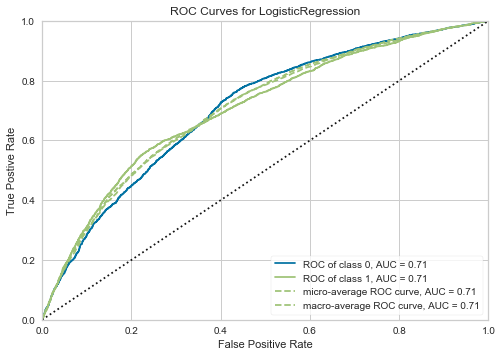

In [52]:
from sklearn.linear_model import LogisticRegression

from yellowbrick.classifier import ROCAUC

# Instantiate the classification model and visualizer
logistic = LogisticRegression()
visualizer = ROCAUC(logistic)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

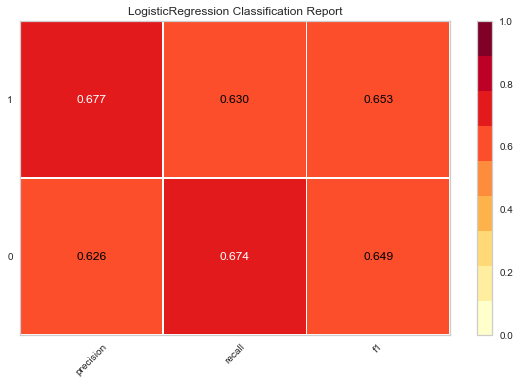

In [53]:
# CLASSIFICATION REPORT
from yellowbrick.classifier import ClassificationReport
from sklearn.linear_model import LogisticRegression
viz = ClassificationReport(LogisticRegression())
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.poof()

# SVM

In [54]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Create classification dataset
X= df_inci_X_SVM_scaled
Y = inci_Y

# classes = ["ARRESTED", "NOT ARRESTED"]
# Perform 80/20 training/test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20,
                                                    random_state=42)

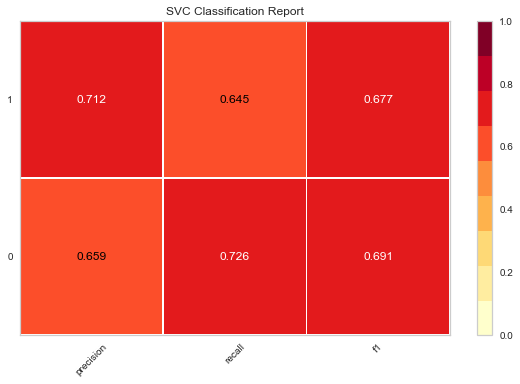

In [55]:
# CLASSIFICATION REPORT
from yellowbrick.classifier import ClassificationReport
# from sklearn.linear_model import SVC
from sklearn.svm import SVC
viz = ClassificationReport(SVC())
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.poof()

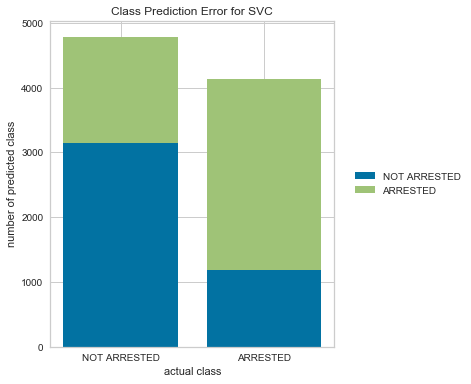

In [56]:
from sklearn.ensemble import RandomForestClassifier

from yellowbrick.classifier import ClassPredictionError

# Instantiate the classification model and visualizer
visualizer = ClassPredictionError(
    SVC(), classes=["NOT ARRESTED","ARRESTED"]
)

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
g = visualizer.poof()

In [58]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from yellowbrick.classifier import ROCAUC

# # Instantiate the classification model and visualizer
# SVM_sample = SVC()
# visualizer = ROCAUC(SVM_sample)

# visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
# visualizer.score(X_test, y_test)  # Evaluate the model on the test data
# g = visualizer.poof()   

###### Key References

https://github.com/eclarson/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb https://github.com/jakemdrew/EducationDataNC/blob/master/2017/Models/2017ComparingSegregatedHighSchoolCampuses.ipynb (Logit) http://www.cs.toronto.edu/~kswersky/wp-content/uploads/svm_vs_lr.pdf

### END OF REPORT